In [1]:
import os
os.chdir('./src')
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import sys
import json
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import numpy as np
#import matplotlib.patches as patches
import matplotlib.pyplot as plt
#import supervision as sv
import requests
import io
import zipfile
from tqdm import tqdm
from time import time

from maxarseg.geoDatasets import Maxar
from maxarseg.samplers import MyGridGeoSampler
from maxarseg.segment import building_gdf, rel_bbox_coords, segment_buildings, rel_road_lines, segment_roads
from maxarseg.samplers_utils import boundingBox_2_Polygon

In [2]:
from segment_anything import sam_model_registry, SamPredictor
root = './'
sam_checkpoint = "models/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=os.path.join(root, sam_checkpoint))
sam.to(device='cuda:3')

predictor = SamPredictor(sam)

In [3]:
data_root = '/mnt/data2/vaschetti_data/maxar'
event_folder = 'Emilia-Romagna-Italy-flooding-may23' ########
dataset = Maxar(os.path.join(data_root, event_folder, 'pre/10300100BF164000/120000301331.tif')) ########
sample_size = 600
stride = 600
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=stride)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
dataset_crs = dataset.crs
dataset_res = dataset.res

Creazione dataset e indice edifici

In [4]:
#inserire qui una funzione che legge qualche immagine a caso dalla cartella dell'evento
#e capisce in quale stato si trova. In modo tale da passarlo a building_gdf

In [90]:
build_gdf

type                      properties  \
0       Feature                 {'height': 5.0}   
1       Feature  {'height': 10.533905982971191}   
2       Feature  {'height': 18.942800521850586}   
3       Feature                {'height': -1.0}   
4       Feature   {'height': 5.544168472290039}   
...         ...                             ...   
166672  Feature   {'height': 8.101701736450195}   
166673  Feature   {'height': 5.770529747009277}   
166674  Feature  {'height': 5.6363983154296875}   
166675  Feature  {'height': 4.9555439949035645}   
166676  Feature   {'height': 4.215744495391846}   

                                                 geometry  
0       POLYGON ((11.24936 44.53208, 11.24941 44.53206...  
1       POLYGON ((11.24939 44.39636, 11.24955 44.39659...  
2       POLYGON ((11.25018 44.56994, 11.25023 44.56993...  
3       POLYGON ((11.25167 44.31589, 11.25172 44.31588...  
4       POLYGON ((11.25544 44.45389, 11.25544 44.45391...  
...                                                   ...  
166672  POLYGON ((12.47033 44.13915, 12.47054 44.13905...  
166673  POLYGON ((12.47052 44.14409, 12.47048 44.14412...  
166674  POLYGON ((12.47138 44.13764, 12.47144 44.13776...  
166675  POLYGON ((12.47223 44.14384, 12.47204 44.14399...  
166676  POLYGON ((12.47621 44.09020, 12.47620 44.09010...  

[276383 rows x 3 columns]

In [91]:
from maxarseg import build

qk_hits = build.intersecting_qks((11.7583, 44.3100),(12.0958,44.5366))
build_gdf = build.qk_building_gdf(qk_hits, csv_path = './metadata/buildings_dataset_links.csv')
proj_build_gdf =  build_gdf.to_crs(dataset_crs)
len(proj_build_gdf)

Found 2 links matching: [120232003, 120232002, 1202320, 12023200]


276383

In [92]:
index_MS_buildings = proj_build_gdf.sindex

In [4]:
state_name = 'PuertoRico' ################
gdfs_32628 = building_gdf(state_name, dataset_crs = dataset_crs)
index_MS_buildings = gdfs_32628.sindex

Found 7 links for PuertoRico


Creazione strade

In [7]:
region_road_df = pd.read_csv('/nfs/projects/overwatch/microsoft-roads/Europe-Full.tsv', names =['country', 'geometry'], sep='\t')

In [8]:
ita_region_road_df = region_road_df[region_road_df['country'] == 'ITA']

In [9]:
print(ita_region_road_df.head())

         country                                           geometry
31220771     ITA  {"type":"Feature","geometry":{"type":"LineStri...
31220776     ITA  {"type":"Feature","geometry":{"type":"LineStri...
31220781     ITA  {"type":"Feature","geometry":{"type":"LineStri...
31220786     ITA  {"type":"Feature","geometry":{"type":"LineStri...
31220791     ITA  {"type":"Feature","geometry":{"type":"LineStri...


In [10]:
ita_region_road_df['geometry'] = ita_region_road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))

/tmp/ipykernel_12040/3256352705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ita_region_road_df['geometry'] = ita_region_road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))


In [11]:
road_gdf = gpd.GeoDataFrame(ita_region_road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

In [12]:
road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30

In [5]:
road_links_df = pd.read_csv(os.path.join(root, 'metadata/roads_links.csv'))
region_name = 'Caribbean Islands' ################
url = road_links_df[road_links_df['region'] == region_name]['link'].values[0]
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
files = zip_file.namelist()

# Assuming the first file in the zip file is the CSV you want to read
with zip_file.open(files[0]) as f:
    road_df = pd.read_csv(f, names =['country', 'geometry'] ,delimiter='\t')
print(road_df.head())

  country                                           geometry
0     AIA  {"type":"Feature","geometry":{"type":"LineStri...
1     AIA  {"type":"Feature","geometry":{"type":"LineStri...
2     AIA  {"type":"Feature","geometry":{"type":"LineStri...
3     AIA  {"type":"Feature","geometry":{"type":"LineStri...
4     AIA  {"type":"Feature","geometry":{"type":"LineStri...


In [6]:
country = 'PRI' ######
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30

In [8]:
"""path = './MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
print(road_df.head())
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30"""

"path = './MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'\nroad_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')\nprint(road_df.head())\ncountry = 'GMB'\nroad_df = road_df[road_df['country'] == country]\nroad_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))\nroad_gdf = gpd.GeoDataFrame(road_df, crs=4326)\nroad_gdf_32628 = road_gdf.to_crs(dataset_crs)\n\nroad_point_dist = 40 #50\nbg_point_dist = 40 #80\noffset_distance = 25 #30"

Creazione Alberi


In [13]:
from groundingdino.util.inference import load_model, predict, annotate
from maxarseg.segment import GD_img_load, filter_on_box_area_mt2, segment_from_boxes, GDboxes2SamBoxes

import groundingdino.datasets.transforms as T
GDINO_root ="./models/GDINO"

CONFIG_PATH = os.path.join(GDINO_root, "GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_PATH = os.path.join(GDINO_root, "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

GDINO_model = load_model(CONFIG_PATH, WEIGHTS_PATH, device = 'cuda')

TEXT_PROMPT = 'green tree' #'house' or 'tree' or 'green tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30

./models/GDINO/GroundingDINO_SwinT_OGC.py ; exist: True
./models/GDINO/groundingdino_swint_ogc.pth ; exist: True
final text_encoder_type: bert-base-uncased


In [14]:
GDINO_model.to('cuda:3')

GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_aff

In [15]:
print('GD model device:', next(GDINO_model.parameters()).device)

GD model device: cuda:3


In [11]:
i = 0
for batch in tqdm(dataloader):
    if i == 8:
        break
    
    #encode the image
    sample = unbind_samples(batch)[0]
    print('sample shape: ', sample["image"].shape)
    img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
    print('img4sam shape: ', img4Sam.shape)
    print('\n')

    #trees
    image_transformed = GD_img_load(img4Sam)
    i += 1

  0%|          | 3/900 [00:00<00:37, 23.81it/s]

In sampler
tile_polygon:  POLYGON ((749843.75 1995156.25, 749843.75 1989843.75, 755156.25 1989843.75, 755156.25 1995156.25, 749843.75 1995156.25))
sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)




  1%|          | 8/900 [00:00<00:33, 26.31it/s]

sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)




In [48]:
import itertools

In [97]:
proj_build_gdf.total_bounds

array([ 678477.69265532, 4886112.20040688,  778629.01745331,
       4942604.97565606])

In [99]:
proj_build_gdf.geometry.intersects(poly).sum()

0

In [74]:
from torchgeo.datasets import BoundingBox
poly = boundingBox_2_Polygon(BoundingBox(minx=735209.9609375, maxx=735393.06640625, miny=4927773.4375, maxy=4927956.54296875, mint=0.0, maxt=9.223372036854776e+18))

In [93]:
index_MS_buildings.query(poly)

array([], dtype=int64)

In [83]:
dataset_crs

CRS.from_epsg(32632)

In [82]:
list(proj_build_gdf.iloc[0].geometry.exterior.coords)

[(678721.9155767919, 4933433.367493036),
 (678726.1053864638, 4933431.475099884),
 (678727.1343642497, 4933433.73703927),
 (678722.9445556592, 4933435.629431037),
 (678721.9155767919, 4933433.367493036)]

In [70]:
import warnings
warnings.filterwarnings('ignore')

i = 0
encoding_times = []
tot_times = []
tot_times_GD = []
f1 = f2 = f3 = False
for batch in tqdm(itertools.islice(dataloader, 250, None)):
    print(i)
    if i >= 4:
        break
    print('prima')
    print(batch['crs'])
    print(batch['bbox'])
    print('dopo')
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0]) #get the polygon of the sampled bbox
    buildig_hits = index_MS_buildings.query(query_bbox_poly)
    print(buildig_hits)
    if buildig_hits < 5:
        print('no build')
        i+=1
        continue

    s_time_whole = time()
    #encode the image
    sample = unbind_samples(batch)[0]
    img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')

    s_encoding_time = time()
    predictor.set_image(img4Sam)
    tot_encoding_time = time() - s_encoding_time
    encoding_times.append(tot_encoding_time)
    

    #query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0]) #get the polygon of the sampled bbox
    
    #buildings
    #buildig_hits = index_MS_buildings.query(query_bbox_poly)
    #Getting the relative coordinates of the buildings boxes
    if len(buildig_hits) != 0:
        print('segmento edifici')
        building_boxes = rel_bbox_coords(gdfs_32628.iloc[buildig_hits], query_bbox_poly.bounds, dataset_res, ext_mt=10)

        building_mask, used_boxes, used_points  =  segment_buildings(predictor, building_boxes,
                                                    img4Sam,
                                                    use_bbox=True,
                                                    use_center_points=False)

    #roads
    road_hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    print('strade:', len(road_hits))
    if len(road_hits) != 0:
        queried_road_gdf_36628 = road_gdf_32628[road_hits]
        road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)

        try: 
            road_mask, road_pt_coords4Sam, road_pt_labels4Sam = segment_roads(predictor,
                                                                            road_lines,
                                                                            sample_size,
                                                                            road_point_dist = road_point_dist,
                                                                            bg_point_dist = bg_point_dist,
                                                                            offset_distance = offset_distance,
                                                                            do_clean_mask=True)
        except:
            i+=1
            continue

    
    #trees
    s_time_GD = time()
    image_transformed = GD_img_load(img4Sam)
    tree_boxes, logits, phrases = predict(GDINO_model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
    tot_times_GD.append(time() - s_time_GD)
    if len(tree_boxes) != 0:
        keep_ix_tree_boxes = filter_on_box_area_mt2(tree_boxes, sample_size, dataset_res, max_area_mt2 = 3000)
        tree_boxes4Sam = GDboxes2SamBoxes(tree_boxes[keep_ix_tree_boxes], sample_size)
        try:
            tree_mask, used_tree_boxes, used_tree_points = segment_from_boxes(predictor, tree_boxes4Sam, img4Sam, use_bbox=True, use_center_points=False)
        except:
            i+=1
            continue

        
    
    tot_times.append(time() - s_time_whole)

    i+=1
    

0it [00:00, ?it/s]

In sampler
tile_polygon:  POLYGON ((734843.75 4924843.75, 734843.75 4928820.950565235, 738197.8264325671 4927384.17269497, 736840.5426560093 4924843.75, 734843.75 4924843.75))
0
prima
[CRS.from_epsg(32632)]
[BoundingBox(minx=737590.33203125, maxx=737773.4375, miny=4927590.33203125, maxy=4927773.4375, mint=0.0, maxt=9.223372036854776e+18)]
dopo
[]
strade: 5348177


1it [00:03,  3.50s/it]

1
prima
[CRS.from_epsg(32632)]
[BoundingBox(minx=734843.75, maxx=735026.85546875, miny=4927773.4375, maxy=4927956.54296875, mint=0.0, maxt=9.223372036854776e+18)]
dopo
[]
strade: 5348177


2it [00:06,  3.14s/it]

2
prima
[CRS.from_epsg(32632)]
[BoundingBox(minx=735026.85546875, maxx=735209.9609375, miny=4927773.4375, maxy=4927956.54296875, mint=0.0, maxt=9.223372036854776e+18)]
dopo
[]
strade: 5348177


3it [00:09,  3.05s/it]

3
prima
[CRS.from_epsg(32632)]
[BoundingBox(minx=735209.9609375, maxx=735393.06640625, miny=4927773.4375, maxy=4927956.54296875, mint=0.0, maxt=9.223372036854776e+18)]
dopo
[]
strade: 5348177


4it [00:12,  3.10s/it]

4


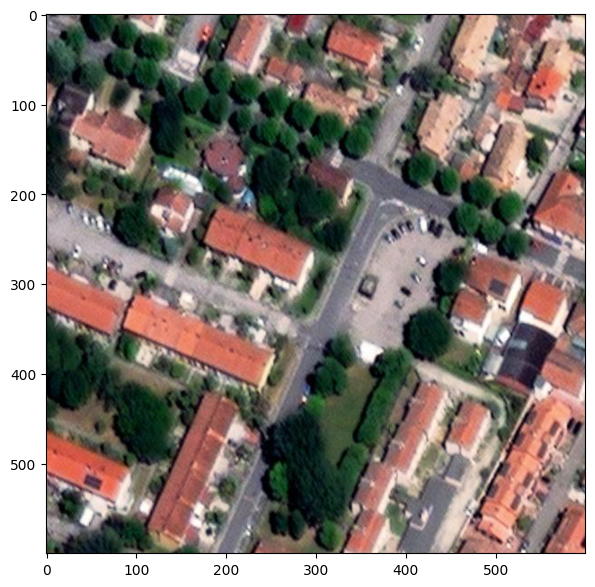

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

In [63]:
tree_mask.shape

(1, 600, 600)

In [64]:
road_mask.shape

(1, 600, 600)

In [65]:
building_mask.shape

NameError: name 'building_mask' is not defined

Labelling time

In [13]:
mean_img_encoding_time = np.array(encoding_times).mean()
mean_tot_time = np.array(tot_times).mean()
print("mean_img_encoding_time (s):", mean_img_encoding_time)
print("mean_tot_time (s):", mean_tot_time)
print("img_encoding_time/mean_tot_time:", mean_img_encoding_time/mean_tot_time)

mean_img_encoding_time (s): 2.2906092007954917
mean_tot_time (s): 2.805026372273763
img_encoding_time/mean_tot_time: 0.8166087932138466


In [14]:
print('Extimated time for a single tile (h):', len(dataloader) * mean_tot_time / (60*60))

Extimated time for a single tile (h): 0.7012565930684408


In [15]:
print('G Dino time(s): ', np.array(tot_times_GD).mean())

G Dino time(s):  0.2588859399159749


Plotting

In [66]:
from maxarseg.plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison

In [86]:
from maxarseg import segment
all_masks_no_over = segment.rmv_mask_overlap(np.stack((tree_mask, road_mask)))

In [21]:
from maxarseg import segment
all_masks_no_over = segment.rmv_mask_overlap(np.stack((tree_mask, road_mask, building_mask)))

In [22]:
all_masks_no_over[0].shape

(1, 600, 600)

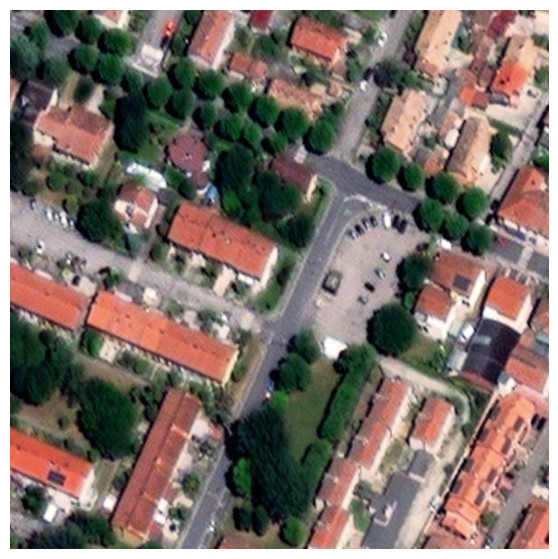

In [89]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

#show_mask(all_masks_no_over[0], plt.gca())
#show_mask(all_masks_no_over[1], plt.gca(), rgb_color = [0, 128, 0])
#show_mask(all_masks_no_over[2], plt.gca(),rgb_color = [160, 116, 196] )

#if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    #show_box(used_boxes, ax, color='r')
    #show_box(used_tree_boxes.tolist(), ax, color='b')
    #show_points(used_tree_points, road_pt_labels4Sam, ax)
    #show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.axis('off')
save_root = './output/imgResults/noGambia'
plt.savefig(save_root+'/original4.png', bbox_inches='tight', pad_inches = 0)
plt.show()

In [27]:
building_mask.shape

(1, 600, 600)

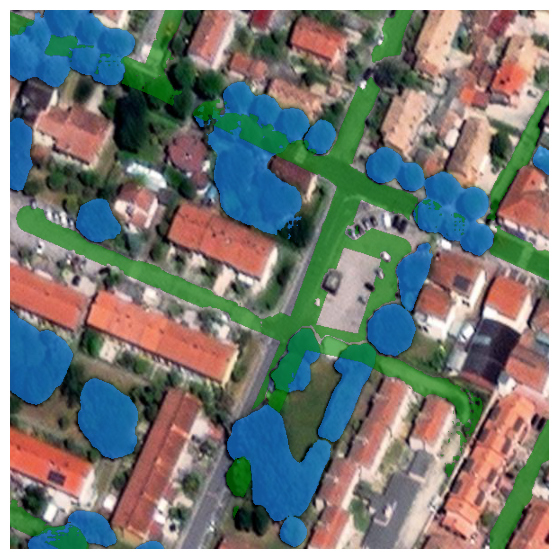

In [85]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

show_mask(tree_mask, plt.gca())
show_mask(road_mask, plt.gca(), rgb_color = [0, 128, 0])
#show_mask(building_mask, plt.gca(),rgb_color = [160, 116, 196] )

#if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    #show_box(used_boxes, ax, color='r')
    #show_box(used_tree_boxes.tolist(), ax, color='b')
    #show_points(used_tree_points, road_pt_labels4Sam, ax)
    #show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.axis('off')
save_root = './output/imgResults/noGambia'
#plt.savefig(save_root+'/originale1.png', bbox_inches='tight', pad_inches = 0)
plt.show()

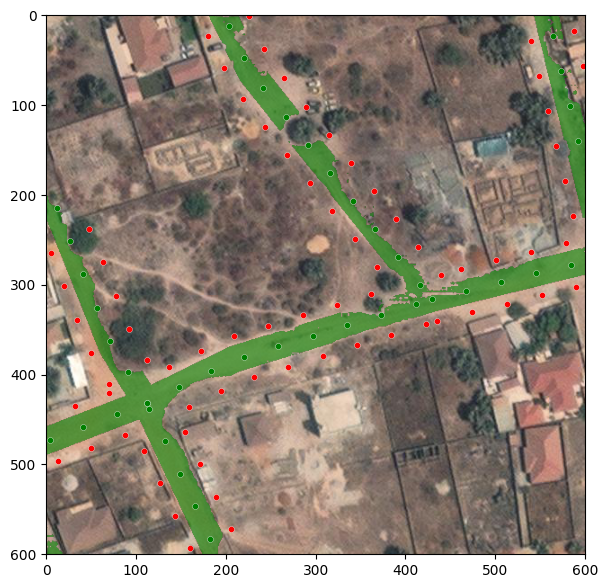

In [70]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

#show_mask(building_mask, plt.gca())
show_mask(road_mask, plt.gca(), rgb_color = [0, 128, 0])

if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    #show_box(used_boxes, ax, color='b')
    show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.show()

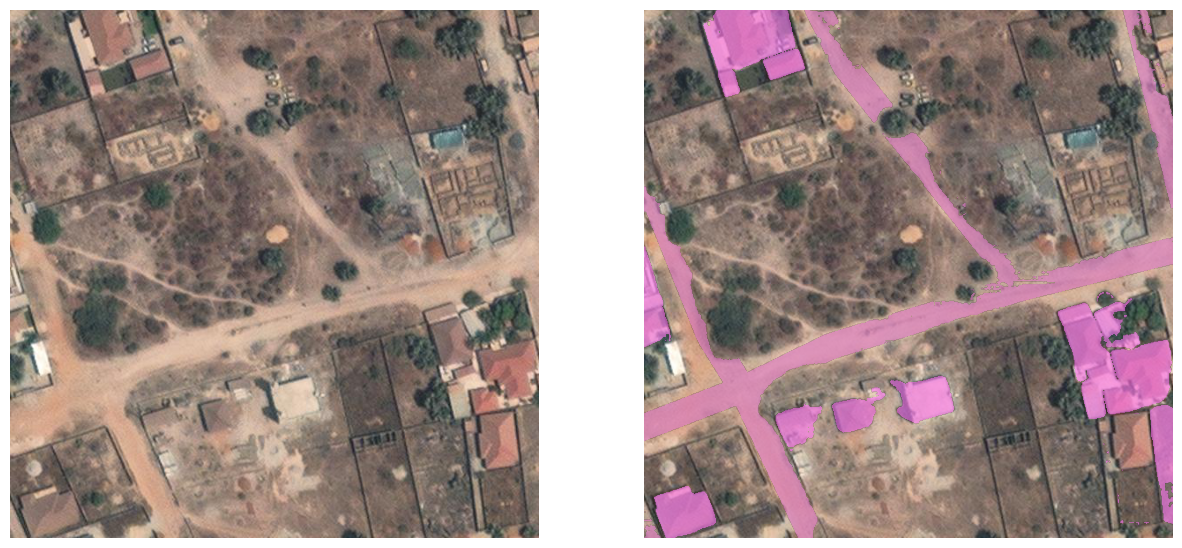

In [48]:
masks = np.vstack((building_mask, road_mask))
plot_comparison(img4Sam, masks)

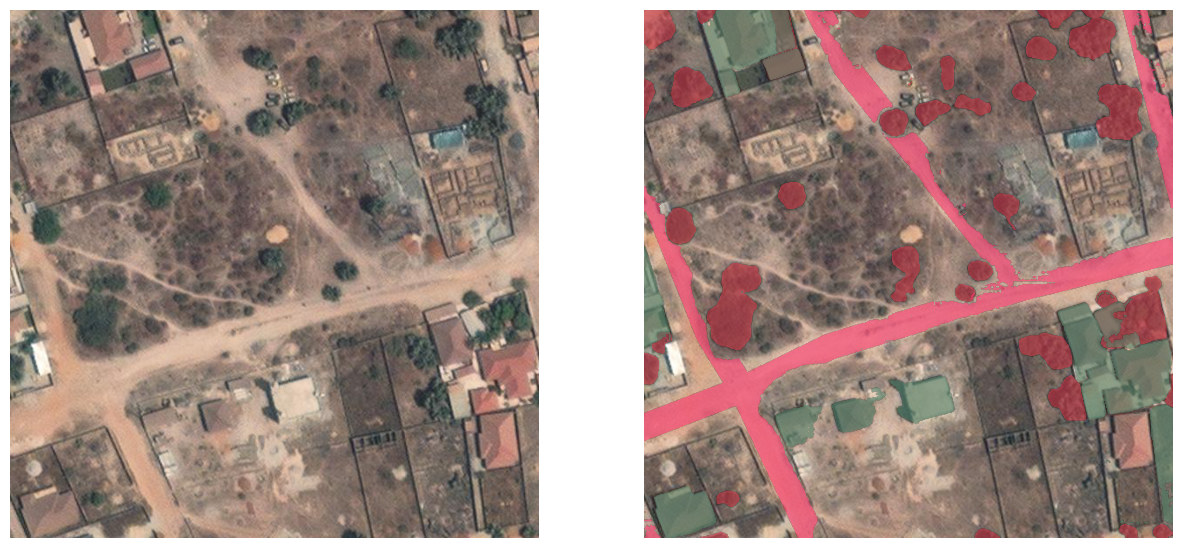

In [49]:
masks = np.vstack((tree_mask, building_mask, road_mask))
plot_comparison(img4Sam, masks)

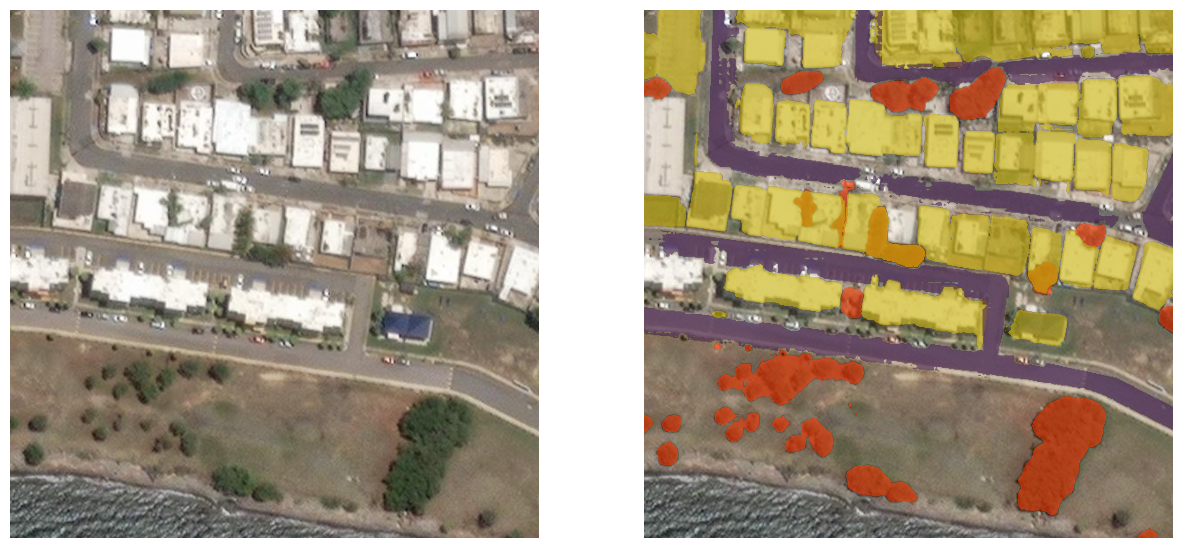

In [33]:
masks = np.vstack((tree_mask, building_mask, road_mask))
plot_comparison(img4Sam, masks)